# EMA of Curacao EV Vensim Model
In this Jupyter Notebook:
1. Setting up experiments and running iterations;
2. Initial Exploration: Scatterplots & Correlation matrices, line plots;
3. Clustering of runs based on behaviour;
4. Scenario Discovery: PRIM & Dimensional Stacking;
5. Sensitivity Analyses: Feature Scoring & Sobol Global SA.

In [1]:
# --- Environment & library setup (clean) 
# ~6 seconds to run

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    RealParameter,
    IntegerParameter,
    CategoricalParameter,
    Constant,
    TimeSeriesOutcome,
    perform_experiments,
    save_results,
    load_results,
    ema_logging,
)
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.analysis import prim, feature_scoring, pairs_plotting, plotting

def print_versions() -> None:
    """Print key environment versions and paths (direct, compact)."""
    import ema_workbench  # local import to avoid polluting top-level namespace

    print(f"EMA version : {ema_workbench.__version__}")
    print(f"EMA path    : {ema_workbench.__file__}")
    print(f"NumPy       : {np.__version__}")
    print(f"Python exe  : {sys.executable}")

# Fix for older numpy versions that do not have np.NAN 
import numpy as np 
if not hasattr(np, "NAN"): np.NAN = np.nan

if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)
    print_versions()


c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\connectors\__init__.py:29: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\connectors\__init__.py:34: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)


EMA version : 2.5.3
EMA path    : c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\__init__.py
NumPy       : 2.3.3
Python exe  : c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\python.exe


## 1. Set up Experiments

In [9]:
# EXPERIMENTAL SETUP OPEN EXPLORATION
# turn on logging
ema_logging.log_to_stderr(ema_logging.INFO) 

# instantiate a model
wd = "./model_files/" # adjust this path to load different version of model
vensim_model = VensimModel("evmodel", wd=wd, model_file="21-10 ochtend.vpmx") # "21-10 ochtend.vpmx" "20-10 eind middag.vpmx"

# ----------------------------
# Categorical switches
# ----------------------------
switches = [
    CategoricalParameter("Energy price switch", (1, 2, 3)),   # 1=Stanford, 2=Twente, 3=IET
    CategoricalParameter("Fuel price switch", (1, 2, 3)),     # 1=high, 2=medium, 3=low
    CategoricalParameter("Emission tax SWITCH", (0, 1)),
    CategoricalParameter("market price scenario switch", (0, 1, 2)),
    CategoricalParameter("SWITCH Policy EV Tax Cut", (0, 1)),
    CategoricalParameter("Dynaf lever SWITCH", (0, 1, 2)),    # 0=normal,1=high,2=very high
]

# ----------------------------
# Real-valued placeholders (hardcoded ±20%)
# ----------------------------
uncertainties = [
    # --- Initial conditions
    IntegerParameter("initial total cars", 62973, 94460),                  # 78717 ±20%
    RealParameter("initial share 0 to 5", 0.12, 0.18),                       # 0.15 ±20%
    RealParameter("initial share 5 to 10", 0.20, 0.30),                      # 0.25 ±20%
    RealParameter("initial share 10 to 15", 0.20, 0.30),                     # 0.25 ±20%
    RealParameter("initial share 15 to 20", 0.16, 0.24),                     # 0.20 ±20%
    RealParameter("initial share 20 plus", 0.12, 0.18),                      # 0.15 ±20%
    RealParameter("initial share of EV", 0.0203, 0.0305),                     # !!!!ISSUE HERE

    # --- Prices & costs
    RealParameter("XCG to Dollar", 1.44, 2.16),                              # 1.8 ±20%
    RealParameter("operational", 0.25032, 0.37548),                          # 0.3129 ±20%
    RealParameter("yearly fee", 274.4, 411.6),                               # 343 ±20%

    # --- Policy / fiscal (continuous parts; switches above)
    RealParameter("Sales Tax", 0.48, 0.72),                                  # 0.6 ±20%
    RealParameter("Policy EV Tax Cut", -0.072, -0.048),                      # -0.06 ±20%
    RealParameter("Policy Start EV Sales Tax[ElectricVehicle]", 2025, 2035),  # 2030 ±20%
    RealParameter("Policy Duration EV Sales Tax[ElectricVehicle]", 8.0, 12.0),    # 10 ±20%

    # --- Efficiency / usage / growth
    RealParameter("fuel efficiency", 0.08, 0.13),                           # (1/8.9) ±20% # !!!!ISSUE HERE
    RealParameter("Average kms driven anually[FossilVehicle]", 8000, 12000),      # 10000 ±20%
    RealParameter("Average kms driven anually[ElectricVehicle]", 8000, 12000),    # 10000 ±20%
    RealParameter('"Car park growth %"', 0.01696, 0.02544),                         # 0.0212 ±20%

    # --- Charging infrastructure (constants-only items)
    RealParameter("initial value facilities[FossilVehicle]", 28, 42),             # 35 ±20%
    RealParameter("initial value facilities[ElectricVehicle]", 25.6, 38.4),       # 32 ±20%
    RealParameter("facility ratio[FossilVehicle]", 0.0016, 0.0024),                 # !!!!ISSUE HERE
    RealParameter("facility ratio[ElectricVehicle]", 0.08, 0.12),                    # !!!!ISSUE HERE
    RealParameter("Facility delay[FossilVehicle]", 0.72, 1.08),                   # 0.9 ±20%
    RealParameter("Facility delay[ElectricVehicle]", 0.56, 0.84),                 # 0.7 ±20%

    # --- Discrete choice (ASC & betas)
    RealParameter("ASC[FossilVehicle]", 0.72, 1.08),                              # 0.9 ±20%
    RealParameter("ASC[ElectricVehicle]", 0.08, 0.12),                            # 0.1 ±20%
    RealParameter("beta range", 0.002032, 0.003048),                              # 0.00254 ±20%
    RealParameter("beta charging distance", -0.336, -0.224),                      # -0.28 ±20%
    RealParameter("beta charge time", -0.001536, -0.001024),                      # -0.00128 ±20%
    RealParameter('"beta fuel/charging costs"', -0.003252, -0.002168),              # (-0.271/100) ±20% # !!!!ISSUE HERE
    RealParameter("beta car price", -6.072e-05, -4.048e-05),                        #   (-0.0506/1000) ±20%  # !!!!ISSUE HERE

    # --- CO2 initial levels (FossilVehicle only; EV kept constant at 0)
    RealParameter("initial CO2 0 to 5 yrs[FossilVehicle]", 92, 138),              # 115 ±20%
    RealParameter("initial CO2 5 to 10 yrs[FossilVehicle]", 120, 180),            # 150 ±20%
    RealParameter("initial CO2 10 to 15 yrs[FossilVehicle]", 136, 204),           # 170 ±20%
    RealParameter("initial CO2 15 to 20 yrs[FossilVehicle]", 144, 216),           # 180 ±20%
    RealParameter("initial CO2 20 yrs plus[FossilVehicle]", 152, 228),            # 190 ±20%
    # --- Out-of-use rates (both vehicle types)
    RealParameter('"out of use % 0 to 5 yr"[FossilVehicle]', 0.0152, 0.0228),       # 0.019 ±20%
    RealParameter('"out of use % 5 to10 yr"[FossilVehicle]', 0.0184, 0.0276),       # 0.023 ±20%
    RealParameter('"out of use % 10 to15 yr"[FossilVehicle]', 0.0408, 0.0612),      # 0.051 ±20%
    RealParameter('"out of use % 15 to 20 yr"[FossilVehicle]', 0.1296, 0.1944),     # 0.162 ±20%
    RealParameter('"out of use % 20 yr plus"[FossilVehicle]', 0.112, 0.168),        # 0.14 ±20%

    RealParameter('"out of use % 0 to 5 yr"[ElectricVehicle]', 0.0152, 0.0228),
    RealParameter('"out of use % 5 to10 yr"[ElectricVehicle]', 0.0184, 0.0276),
    RealParameter('"out of use % 10 to15 yr"[ElectricVehicle]', 0.0408, 0.0612),
    RealParameter('"out of use % 15 to 20 yr"[ElectricVehicle]', 0.1296, 0.1944),
    RealParameter('"out of use % 20 yr plus"[ElectricVehicle]', 0.112, 0.168),

# PARAMETERS WITH ISSUES
    RealParameter("initial share of EV", 0.0203, 0.0305),
    RealParameter("fuel efficiency", 0.08, 0.13),
    RealParameter("facility ratio[FossilVehicle]", 0.0016, 0.0024),
    RealParameter("facility ratio[ElectricVehicle]", 0.08, 0.12),
    RealParameter('"beta fuel/charging costs"', -0.003252, -0.002168),
    RealParameter("beta car price", -6.072e-05, -4.048e-05),
]

# Register on the model
vensim_model.uncertainties = uncertainties + switches

vensim_model.outcomes = [
    TimeSeriesOutcome("Number of EVs"),
    TimeSeriesOutcome("Total CO2 emissions cars[FossilVehicle]"),
# TimeSeriesOutcome("Accumulated CO2 Emissions"),
    ]
 
# RUN THE EXPERIMENTS
results = perform_experiments(vensim_model, 100)

# split results into experiments and outcomes
experiments, outcomes = results

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
100%|████████████████████████████████████████| 100/100 [00:05<00:00, 17.53it/s]
[MainProcess/INFO] experiments finished


#### Save/load results [comment out if not necessary]

In [ ]:
# Save results  
#save_results(results, "./results/ev_results.tar.gz")

c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\em_framework\outcomes.py:541: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")


[MainProcess/INFO] results saved successfully to c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\ev_results.tar.gz


In [9]:
# Load results
#experiments, outcomes = load_results("./results/ev_results.tar.gz")

In [4]:
#outcomes

## 2. Initial Exploration

### Pairplot

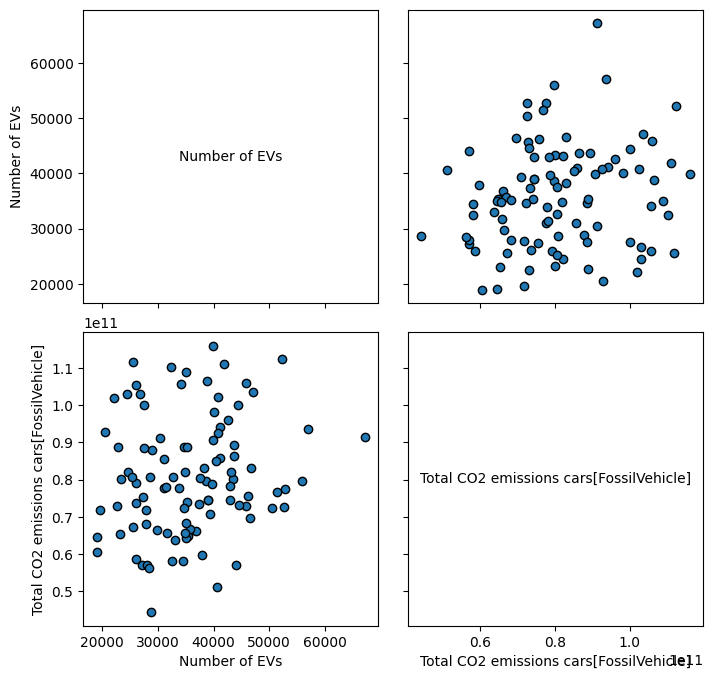

In [10]:
fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, legend=False
)
fig.set_size_inches(8, 8)
plt.show()

### Correlation Matrix

In [11]:
# Selecting the rows and columns so we can compare the outcomes with the uncertainties
#bottom_4_rows_first_10_cols = correlation_matrix.tail(4).iloc[:, :19]

# Plot heatmap of the selected subset
#plt.figure(figsize=(16, 8))
#sns.heatmap(bottom_4_rows_first_10_cols,
#            annot=True,
#            fmt=".2f",
#            cmap="coolwarm",
#            vmin=-1, vmax=1,
#            square=True,
#            linewidths=0.5,
#            cbar_kws={"shrink": 0.75})

#plt.title("Correlation Matrix", fontsize=16)
#plt.tight_layout()
#plt.show()

### Runs Overview

(<Figure size 640x480 with 2 Axes>,
 {'Number of EVs': <Axes: xlabel='Time'>,
  'Total CO2 emissions cars[FossilVehicle]': <Axes: xlabel='Time'>})

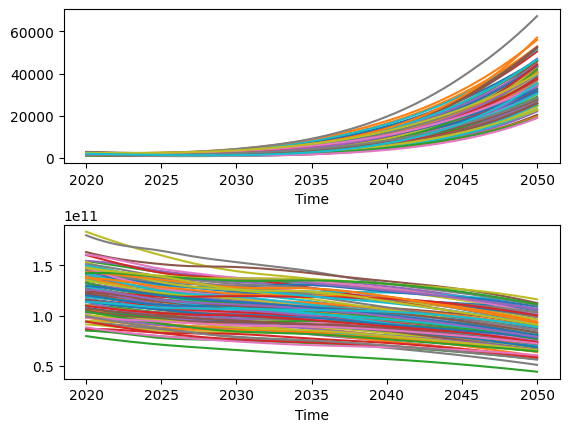

In [11]:
# plotting all lines
plotting.lines(experiments, outcomes, 
               outcomes_to_show=None, group_by=None, 
               grouping_specifiers=None, density='', 
               legend=True, titles=True, ylabels=None, 

               experiments_to_show=None, show_envelope=False, log=False)



(<Figure size 640x480 with 2 Axes>,
 {'Number of EVs': <Axes: title={'center': 'Number of EVs'}, xlabel='Time', ylabel='Number of EVs'>,
  'Total CO2 emissions cars[FossilVehicle]': <Axes: title={'center': 'Total CO2 emissions cars[FossilVehicle]'}, xlabel='Time', ylabel='Total CO2 emissions cars[FossilVehicle]'>})

<Figure size 640x480 with 0 Axes>

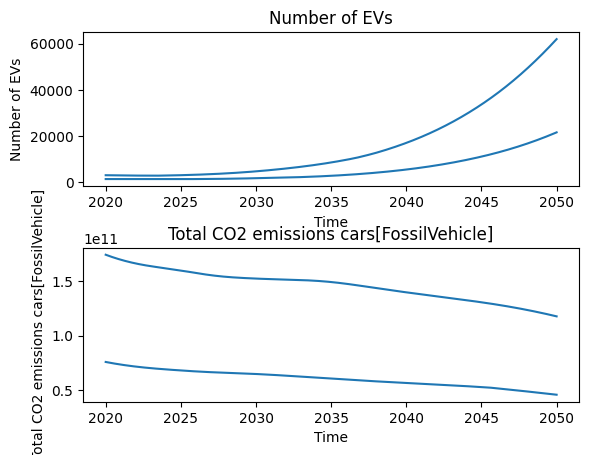

In [7]:
# envelope plot
plt.tight_layout()

plotting.envelopes(experiments, outcomes,
                    outcomes_to_show=None, 
                    group_by=None, grouping_specifiers=None, 
                    density=None, fill=False, legend=True, 
                    titles={}, ylabels={}, log=False)

[MainProcess/WARNING] error in determine_kde: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\analysis\plotting_util.py:369: RuntimeWarning: invalid value encountered in divide
  kde_x = kde_x / np.max(kde_x)


(<Figure size 640x480 with 6 Axes>,
 {'Number of EVs': <Axes: xlabel='time', ylabel='Number of EVs'>,
  'Total CO2 emissions cars[FossilVehicle]': <Axes: xlabel='time', ylabel='Total CO2 emissions cars[FossilVehicle]'>,
  'Accumulated CO2 Emissions': <Axes: xlabel='time', ylabel='Accumulated CO2 Emissions'>})

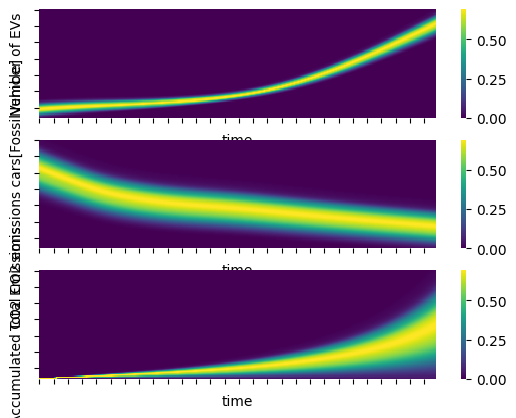

In [14]:
# KDE over time (30 seconds to run)
plotting.kde_over_time(experiments, outcomes, 
                       outcomes_to_show=None, 
                       group_by=None, grouping_specifiers=None, 
                       colormap='viridis', log=True)


## 3. Clustering Runs

In [15]:
from ema_workbench.analysis import clusterer

# ----------------------------
# Distance choices
# ----------------------------
def compute_distance(data: pd.DataFrame, method: str = "cid") -> np.ndarray:
    """
    Compute pairwise distances between time series stored column-wise or row-wise.
    Expects `data` shaped (n_cases, T) or a Series of arrays/lists.
    method: "cid" (Complexity Invariant Distance) or "euclidean"
    """
    # Accept Series of arrays OR 2D frame
    if isinstance(data, pd.Series):
        Y = np.stack([np.asarray(v, dtype=float) for v in data.values], axis=0)
    elif isinstance(data, pd.DataFrame):
        # If each row is a case and each column is a time step, keep as-is
        # If each column is a case, transpose
        Y = data.to_numpy()
        if Y.shape[0] < Y.shape[1] and np.ndim(Y) == 2 and data.index.name != "case":
            # heuristic: more columns than rows likely means columns are time; keep as rows=cases
            pass
    else:
        Y = np.asarray(data, dtype=float)

    if method.lower() == "cid":
        # ema_workbench expects a pandas Series of arrays, so convert back
        series = pd.Series([Y[i, :] for i in range(Y.shape[0])])
        D = clusterer.calculate_cid(series)
    elif method.lower() == "euclidean":
        D = clusterer.calculate_euclidean(Y)
    else:
        raise ValueError(f"Unknown method '{method}'. Use 'cid' or 'euclidean'.")
    return D


def apply_clustering(distances: np.ndarray, n_clusters: int) -> np.ndarray:
    """
    Agglomerative clustering on a precomputed distance matrix using ema_workbench helper.
    Returns integer labels of length n_cases.
    """
    labels = clusterer.apply_agglomerative_clustering(
        distances, n_clusters=n_clusters
    )
    return labels


# ----------------------------
# Pre-processing helpers
# ----------------------------
def normalise_to_start(ts: np.ndarray) -> np.ndarray:
    start = ts[0]
    return ts / start if start not in (0, np.nan) else ts

def smooth(ts: np.ndarray, window: int = 1) -> np.ndarray:
    if window <= 1:
        return ts
    k = int(window)
    cumsum = np.cumsum(np.insert(ts, 0, 0.0))
    out = (cumsum[k:] - cumsum[:-k]) / float(k)
    # keep length same: simple pad at start
    pad = np.repeat(out[0], k-1) if len(out) > 0 else np.array([])
    return np.concatenate([pad, out])


def prepare_outcome_matrix(outcome_series_like, normalise: bool = True, smooth_window: int = 1) -> np.ndarray:
    """
    Accepts:
    - pd.Series of arrays/lists (each element a time series)
    - pd.DataFrame shaped (n_cases, T)
    Returns np.ndarray (n_cases, T) after optional normalisation and smoothing.
    """
    if isinstance(outcome_series_like, pd.Series):
        Y = [np.asarray(v, dtype=float) for v in outcome_series_like.values]
    elif isinstance(outcome_series_like, pd.DataFrame):
        Y = [row.values.astype(float) for _, row in outcome_series_like.iterrows()]
    else:
        # assume array-like
        Y = [np.asarray(v, dtype=float) for v in outcome_series_like]

    Yp = []
    for ts in Y:
        tmp = ts.copy()
        if normalise:
            tmp = normalise_to_start(tmp)
        if smooth_window and smooth_window > 1:
            tmp = smooth(tmp, window=int(smooth_window))
        Yp.append(tmp)
    return np.stack(Yp, axis=0)


# ----------------------------
# Public API
# ----------------------------
def cluster_time_series(
    experiments: pd.DataFrame,
    outcomes: pd.DataFrame | pd.Series,
    outcome_column: str,
    n_clusters: int = 3,
    distance: str = "cid",
    normalise: bool = True,
    smooth_window: int = 1,
) -> dict:
    """
    Cluster outcome time series for a given outcome column, return labels and enriched frames.

    Parameters
    ----------
    experiments : DataFrame
        Rows = runs/cases, columns = uncertainties/levers/etc.
    outcomes : DataFrame or Series
        If DataFrame: rows = runs/cases, columns = time steps for the chosen outcome (T columns),
        OR a wide outcome table from EMA you subselect by `outcome_column`.
        If Series: each element is a 1D array-like time series.
    outcome_column : str
        Name of the outcome to use (if `outcomes` is a wide table). If `outcomes` is already a Series of time series, pass any label (ignored).
    n_clusters : int
    distance : "cid" or "euclidean"
    normalise : bool
    smooth_window : int >= 1

    Returns
    -------
    dict with keys:
      - labels: np.ndarray of cluster labels
      - distances: distance matrix (n x n)
      - experiments_labeled: experiments with 'cluster' column
      - outcome_matrix: np.ndarray (n, T) after pre-processing
    """
    # Select / format the outcome as per input
    if isinstance(outcomes, pd.DataFrame) and outcome_column in outcomes.columns:
        # Case 1: outcomes wide with multi-var columns — here we expect that `outcomes[outcome_column]`
        # stores a Series of arrays (typical EMA results format).
        outcome_series = outcomes[outcome_column]
    elif isinstance(outcomes, pd.DataFrame) and outcome_column not in outcomes.columns:
        # Case 2: outcomes is a pure time-indexed sub-DataFrame (n, T) for a single variable
        # User passed a name but we ignore it.
        outcome_series = outcomes
    elif isinstance(outcomes, pd.Series):
        # Series of arrays
        outcome_series = outcomes
    else:
        raise ValueError("`outcomes` must be a DataFrame or Series holding the chosen outcome time series.")

    # Pre-process to (n, T)
    Y = prepare_outcome_matrix(outcome_series, normalise=normalise, smooth_window=smooth_window)

    # Compute distances and clusters
    # Convert back to a Series of arrays if we use CID
    if distance.lower() == "cid":
        D = clusterer.calculate_cid(np.asarray(Y, dtype=float))      # 2-D array (n_cases, T)
    elif distance.lower() == "euclidean":
        D = clusterer.calculate_euclidean(np.asarray(Y, dtype=float)) # also 2-D
    else:
        raise ValueError("Unknown distance; use 'cid' or 'euclidean'.")

    labels = apply_clustering(D, n_clusters=n_clusters)

    # Attach to experiments
    exp_labeled = experiments.copy()
    exp_labeled["cluster"] = labels.astype("int32")

    return {
        "labels": labels,
        "distances": D,
        "experiments_labeled": exp_labeled,
        "outcome_matrix": Y,
    }

def plot_clusters_overlay(Y: np.ndarray, labels: np.ndarray, time=None, max_examples_per_cluster=50, title=None):
    """
    Overlay all time series by cluster. Y shape (n, T).
    """
    n, T = Y.shape
    if time is None:
        time = np.arange(T)

    k = int(labels.max()) + 1
    fig, axes = plt.subplots(1, k, figsize=(4*k, 3), sharey=True)
    if k == 1:
        axes = [axes]

    for c in range(k):
        ax = axes[c]
        idx = np.where(labels == c)[0]
        # downsample for readability
        if len(idx) > max_examples_per_cluster:
            idx = np.random.RandomState(0).choice(idx, size=max_examples_per_cluster, replace=False)
        ax.plot(time, Y[idx, :].T, alpha=0.2)
        ax.set_title(f"Cluster {c} (n={np.sum(labels==c)})")
        ax.set_xlabel("Time")
    axes[0].set_ylabel("Normalised value")
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    return fig, axes


def pairplot_inputs(exp_labeled: pd.DataFrame, input_cols: list[str], hue: str = "cluster", height=2.0):
    """
    Seaborn pairplot to see which inputs separate clusters.
    """
    grid = sns.pairplot(exp_labeled, vars=input_cols, hue=hue, corner=True, plot_kws=dict(alpha=0.6), height=height)
    plt.show()
    return grid

In [16]:
# check which outcomes we can cluster for:

print(list(outcomes.keys()))

['TIME', 'Number of EVs', 'Total CO2 emissions cars[FossilVehicle]', 'Accumulated CO2 Emissions']


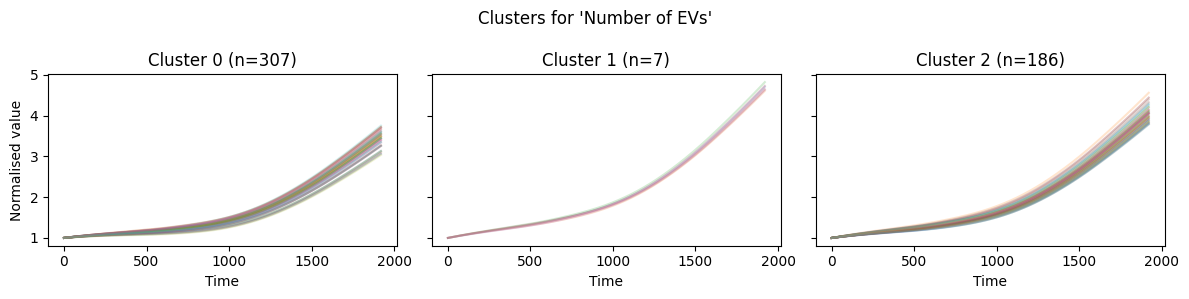

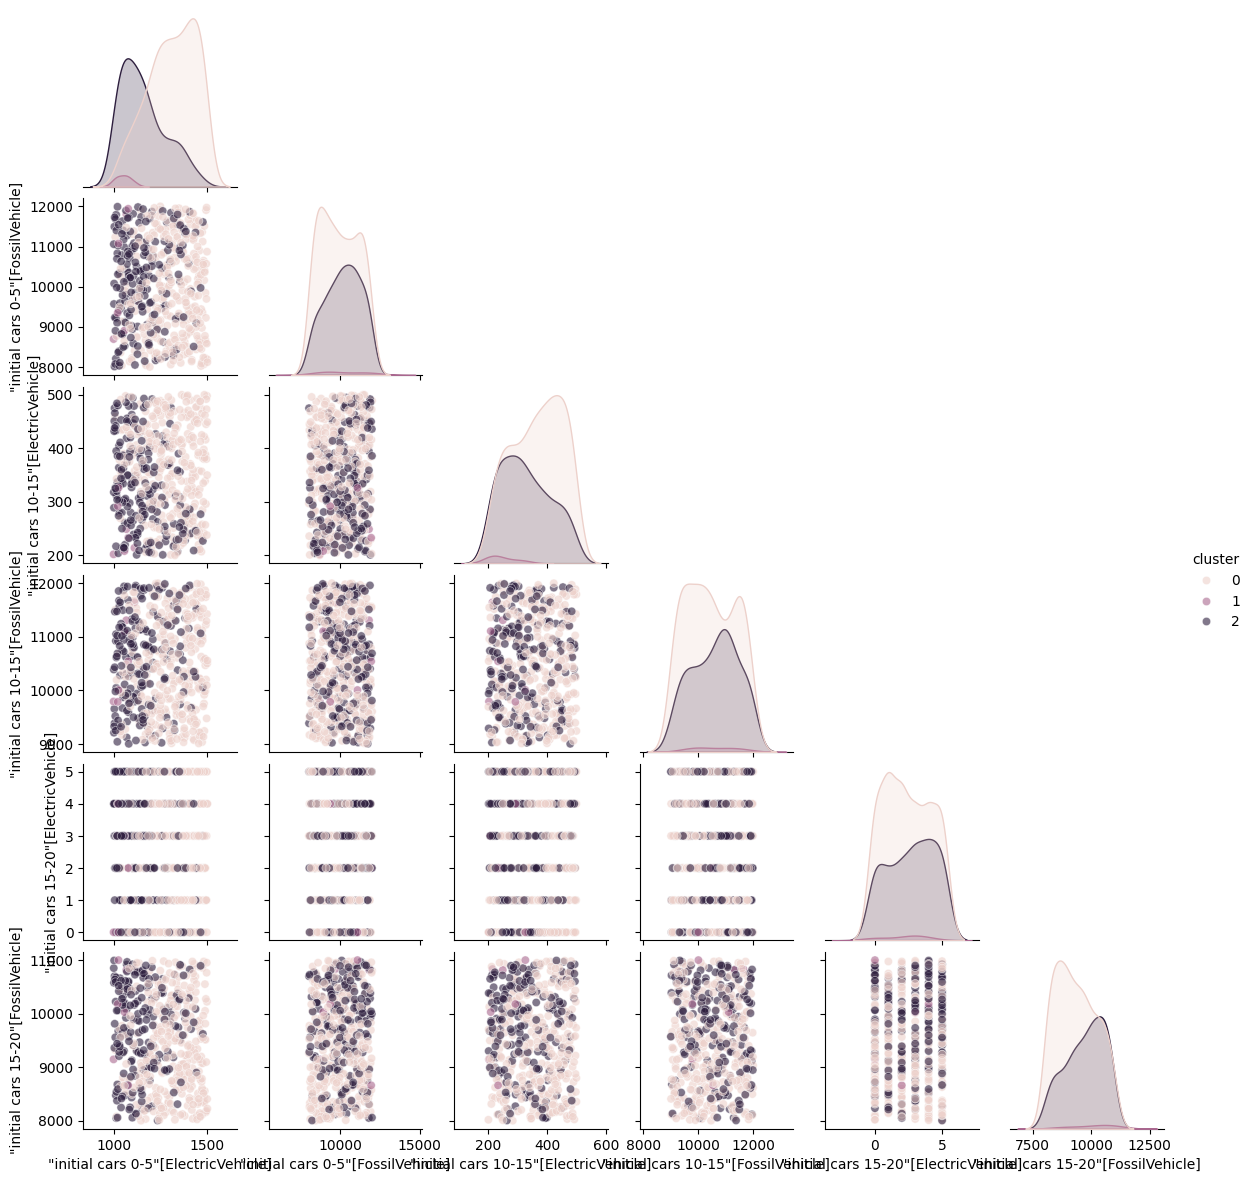

In [17]:
# --- pick the outcome you want to cluster on ---
# Tip: print(list(outcomes.keys())) to see all names
outcome_name = 'Number of EVs'   # <-- change to your outcome to be clustered on

# --- convert EMA outcomes -> Series of 1D arrays (required by our utilities) ---
arr = outcomes[outcome_name]

# Safety: make sure it's (n_cases, T); if transposed, fix it.
if arr.ndim != 2:
    raise ValueError(f"Outcome '{outcome_name}' must be 2D (n_cases, T); got shape {arr.shape}")
n_cases, T = arr.shape

# Build a Series-of-arrays, one time series per run
outcome_series = pd.Series([arr[i, :].astype(float) for i in range(n_cases)], name=outcome_name)

# Optional: extract a time axis if present in outcomes
time = None
for key in ("time", "TIME", "Time"):
    if key in outcomes and outcomes[key].ndim == 1 and outcomes[key].shape[0] == T:
        time = outcomes[key]
        break

# --- run clustering ---
res = cluster_time_series(
    experiments=experiments,         # from results
    outcomes=outcome_series,         # Series of arrays
    outcome_column=outcome_name,     # ignored for Series input (kept for API symmetry)
    n_clusters=3,                    # adjust
    distance="cid",                  # CID
    normalise=True,                  # scale to same start so clusters focus on shape
    smooth_window=1                  # increase (e.g., 3–5) if noisy
)

labels = res["labels"]
Y = res["outcome_matrix"]           # shape (n_cases, T) after preprocessing
exp_labeled = res["experiments_labeled"]

# --- visuals & quick diagnostics ---
_ = plot_clusters_overlay(Y, labels, time=time, title=f"Clusters for '{outcome_name}'")

# Inspect which inputs differ between clusters (pick a shortlist of inputs)
some_inputs = experiments.columns.tolist()[:6]   # or a curated list
_ = pairplot_inputs(exp_labeled, input_cols=some_inputs)


## 4. Scenario Discovery

### Patient-Rule Induction Method (PRIM)

In [7]:

x = experiments

ev_ts = outcomes["Number of EVs"]
final_evs = ev_ts[:, -1] # pick the last time step (or the column == 30 if your columns are time labels)

cutoff = np.percentile(final_evs, 20)   # 20th percentile
y = final_evs < cutoff

In [8]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 100 points remaining, containing 20 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.17, coverage: 0.85, density: 1.0 restricted_dimensions: 16


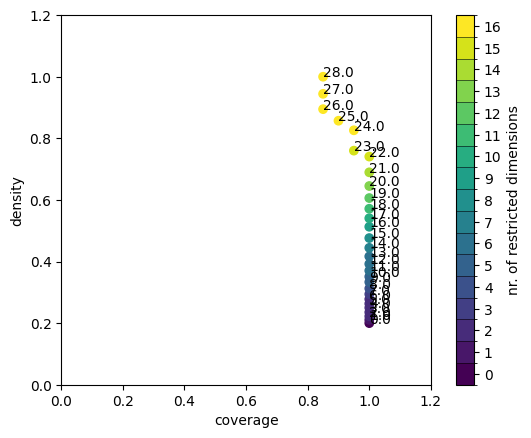

In [9]:
box1.show_tradeoff(annotated=True)
plt.show()

''

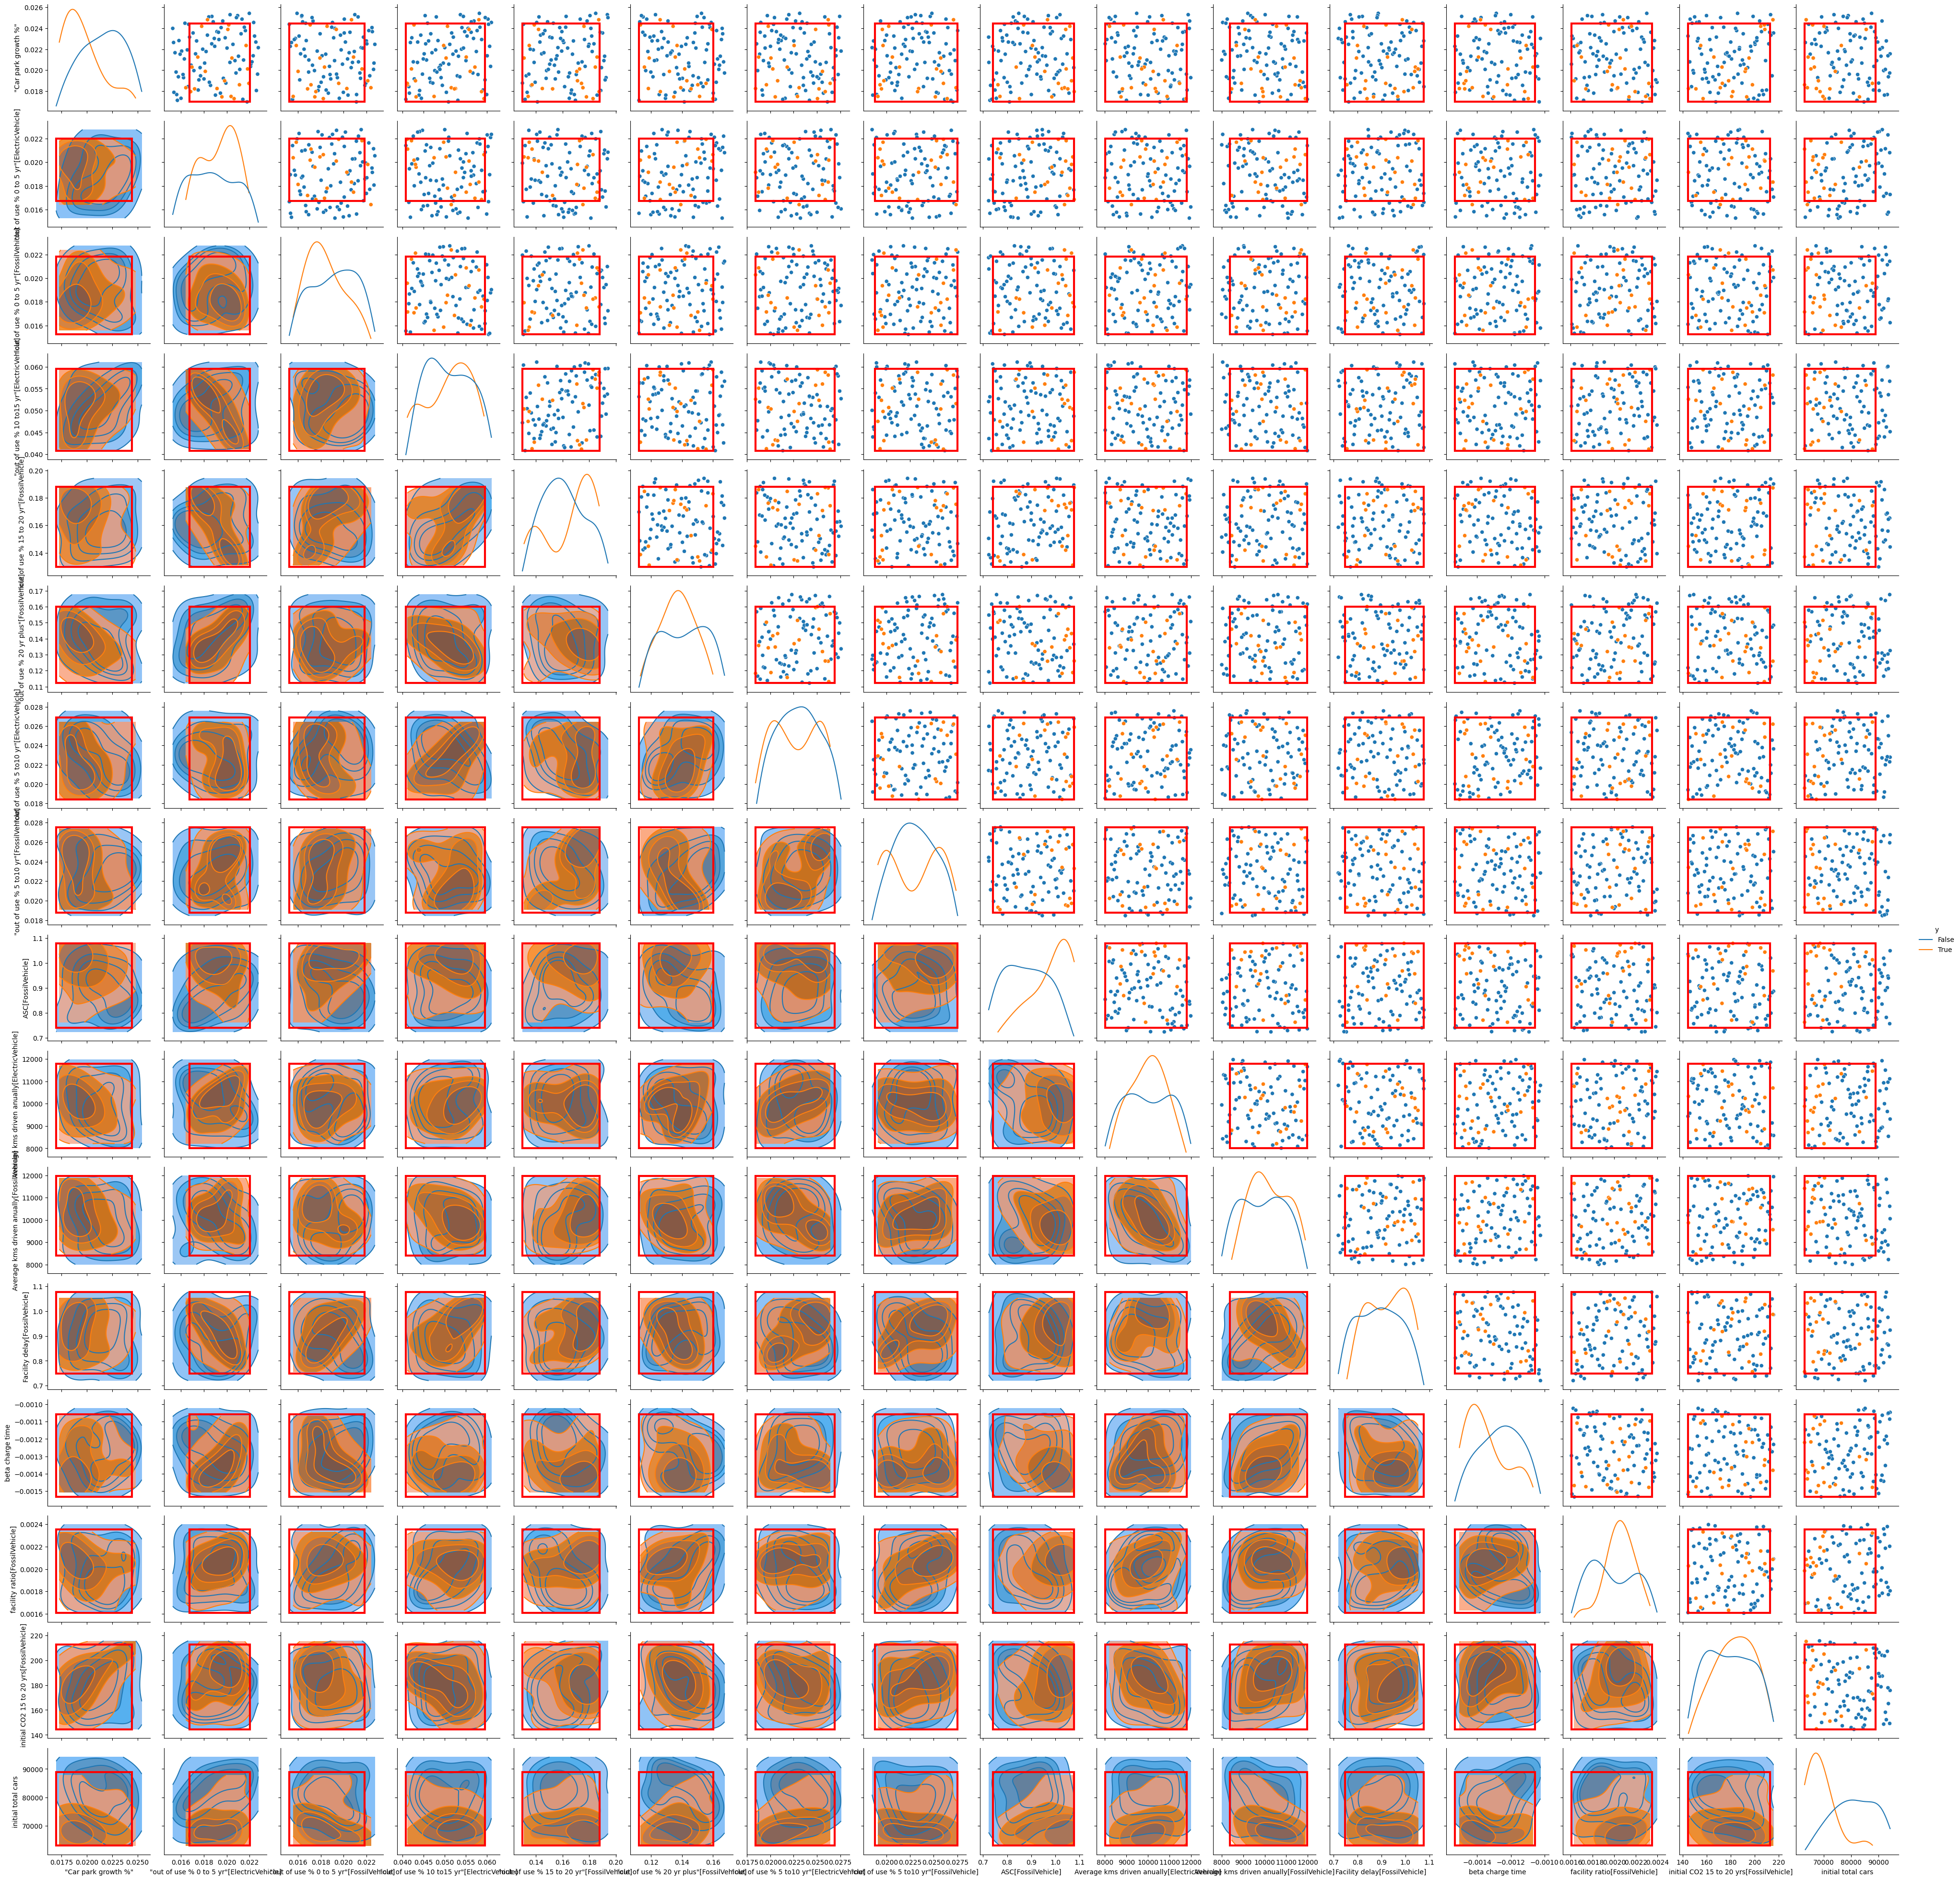

In [10]:
# Scatter plot of box boundaries, for n=1000 takes ~ 1 min
box1.show_pairs_scatter()        # visualize relationships inside/outside box
;

### Dimensional Stacking

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


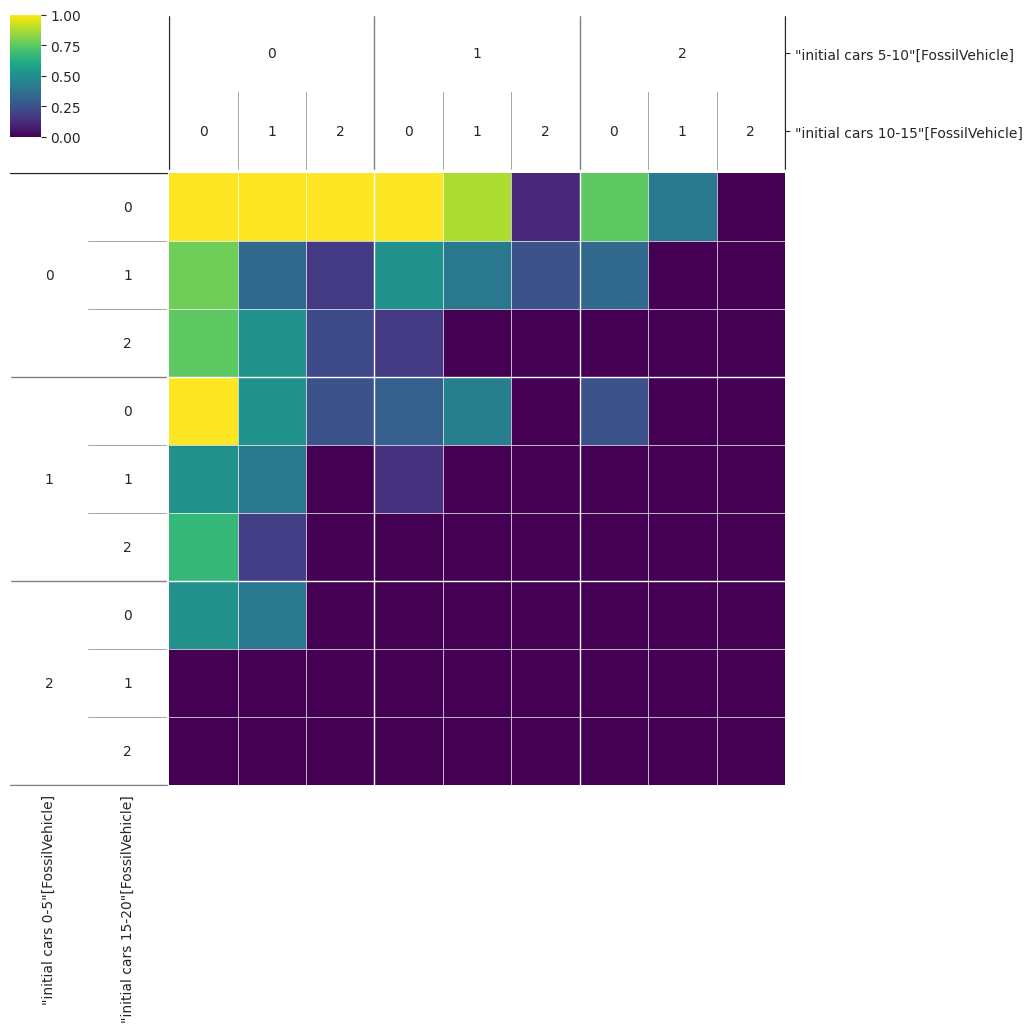

In [ ]:
# NOT DONE YET, SPECIFY VARIABLES OF INTEREST
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = final_evs < cutoff 
dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
plt.show()

## 5. Sensitivity Analysis

### Feature Scoring

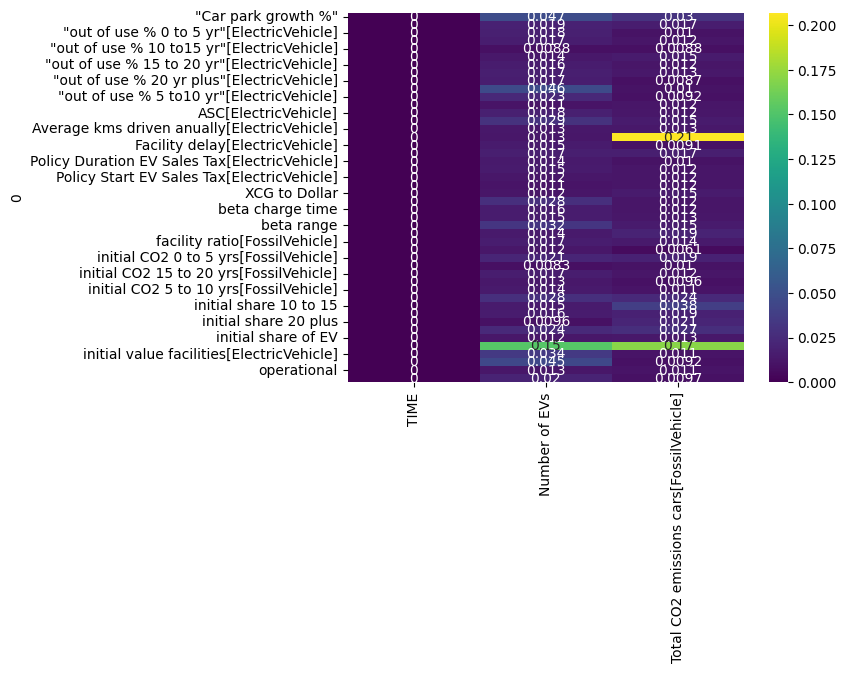

In [8]:
# for n=500 takes ~30 sec
x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

### Sobol Global SA

In [ ]:
# PLACEHOLDER